In [1]:
import pyopencl as cl
from pyopencl.elementwise import ElementwiseKernel
import pyopencl.array as cla
import pyopencl.clmath as clm
from pyopencl.elementwise import ElementwiseKernel
import numpy as np
import math
import time
import soundfile
from scipy import signal as sgn
import gammatone.filters as oldfilt
import gammatonecl.filters as newfilt
from matplotlib import pyplot as plt
from tqdm import tqdm
from pyopencl.scan import GenericScanKernel

ctx = cl.create_some_context()
q = cl.CommandQueue(ctx)
M_PI = 3.14159265358979323846
BW_CORRECTION = 1.0190

def erb(x):
    return 24.7 * ( 4.37e-3 * x + 1.0 )

In [2]:
samples, fs = soundfile.read('04 Traffic and Weather.flac')
samples = np.ascontiguousarray(samples[:9557352, 0])
samp_g = cla.to_device(q, samples)
coseed = 1
sineed = 0
tpt = (M_PI + M_PI) / 44100
tptbw = tpt * erb ( 5512.5 ) * BW_CORRECTION
coscf = math.cos(tpt*5512.5)
sincf = math.cos(tpt*5512.5)
ts = np.arange(0, len(samples), dtype=np.float64)
decay = np.exp(-tptbw)
gain = np.float64((tptbw ** 4) / 3)

In [3]:
q_maker = ElementwiseKernel(ctx,
                            "double *qcos, double *qsin, double *t, double tpt, double cf",
                            "qcos[i] = cos(tpt * cf * t[i]); qsin[i] = - sin(tpt * cf * t[i])"
                            )

In [4]:
t0 = time.time()
ts_g = cla.to_device(q, ts)
qcos = cla.empty_like(ts_g)
qsin = cla.empty_like(ts_g)
q_maker(qcos, qsin, ts_g, tpt, 5512.5)
cosx = samp_g * qcos
sinx = samp_g * qsin
print(f'That took {time.time() - t0} seconds.')
# qcos and qsin can be preprocessed very quickly



That took 0.06407308578491211 seconds.


In [5]:
p0 = GenericScanKernel(ctx, np.float64,
                            arguments='double *x, double *y',
                            preamble=f'__constant double d = {decay};',
                            neutral='0',
                            input_expr='x[i]',
                            scan_expr='b',
                            output_statement="""y[i] = item + d*prev_item"""
                            )

p1 = GenericScanKernel(ctx, np.float64,
                       arguments='double *x',
                       preamble='__constant double d = 0.9139569249435527;',
                       neutral='0',
                       input_expr='x[i]',
                       scan_expr='b',
                       output_statement="x[i]= item - d*d*prev_item")

p2 = GenericScanKernel(ctx, np.float64,
                       arguments='double *x',
                       preamble='__constant double d = 0.9139569249435527;',
                       neutral='0',
                       input_expr='x[i]',
                       scan_expr='b',
                       output_statement="x[i]= item + 2*d*d*d*prev_item")

p3 = GenericScanKernel(ctx, np.float64,
                       arguments='double *x',
                       preamble='__constant double d = 0.9139569249435527;',
                       neutral='0',
                       input_expr='x[i]',
                       scan_expr='b',
                       output_statement="x[i]= item - d*d*d*d*prev_item")

u0 = ElementwiseKernel(ctx,
                       'double *p0, double *p1, double *p2, double *y',
                       'y[i] = p0[i] + 4.0 * d * p1[i] + d*d*p2[i]',
                       preamble='__constant double d = 0.9139569249435527;')

bm_maker = ElementwiseKernel(ctx,
                             'double *ur, double *ui, double *qcos, double *qsin, double *y',
                             'y[i] = (ur[i] * qcos[i] + ui[i] * qsin[i]) * 2.1842638127896094e-05')


shift = ElementwiseKernel(ctx,
                          "double *x",
                          "x[i] = x[i+1]")

That took 0.10697388648986816 seconds


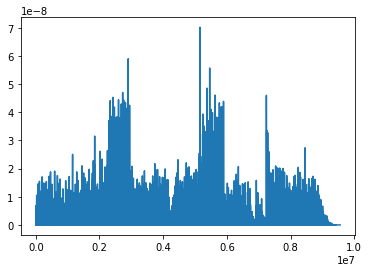

In [6]:
bm_g = cla.empty_like(ts_g)
p0r_g = cla.empty_like(ts_g)
p0i_g = cla.empty_like(ts_g)
ur_g = cla.empty_like(ts_g)
ui_g = cla.empty_like(ts_g)
t0 = time.time()
p0(cosx, p0r_g)
p0(sinx, p0i_g)
p1(p0r_g)
p1(p0i_g)
p2(p0r_g)
p2(p0i_g)
p3(p0r_g)
p3(p0i_g)
p1r_g = p0r_g.copy(q)
shift(p1r_g)
p2r_g = p1r_g.copy(q)
shift(p2r_g)

p1i_g = p0i_g.copy(q)
shift(p1i_g)
p2i_g = p1i_g.copy(q)
shift(p2i_g)
u0(p0r_g, p1r_g, p2r_g, ur_g)
u0(p0i_g, p1i_g, p2i_g, ui_g)
bm_maker(ur_g, ui_g, qcos, qsin, bm_g)
x = (bm_g**2).get()
print(f'That took {time.time() - t0} seconds')
plt.plot(x)

that took 0.6363475322723389 seconds


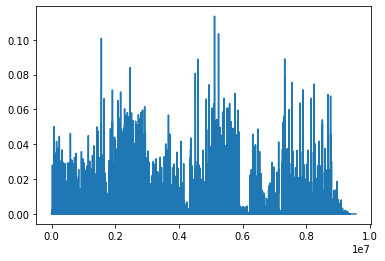

In [44]:
from gammatone import gtgram
t0 = time.time()
coefs = gtgram.make_erb_filters(44100, 5512.5)
x = gtgram.erb_filterbank(samples, coefs)[0]
x=np.power(x, 2)
print(f'that took {time.time() - t0} seconds')
plt.plot(x)

In [8]:
p0 = GenericScanKernel(ctx, np.float64,
                            arguments='double *x, double *y, double d',
                            neutral='0',
                            input_expr='x[i]',
                            scan_expr='b*d',
                            output_statement="""y[i] = item - d*d*prev_item"""
                            )

p1 = GenericScanKernel(ctx, np.float64,
                       arguments='double *x, double d',
                       neutral='0',
                       input_expr='x[i]',
                       scan_expr='b*d*d*d',
                       output_statement="x[i]= item - d*d*d*d*prev_item")

u0 = ElementwiseKernel(ctx,
                       'double *p0, double *p1, double *p2, double *y, double d',
                       'y[i] = p0[i] + 4.0 * d * p1[i] + d*d*p2[i]')

bm_maker = ElementwiseKernel(ctx,
                             'double *ur, double *ui, double *qcos, double *qsin, double *y, double g',
                             'y[i] = (ur[i] * qcos[i] + ui[i] * qsin[i]) * g')


shift = ElementwiseKernel(ctx,
                          "double *x",
                          "x[i] = x[i+1]")

That took 0.08082342147827148 seconds


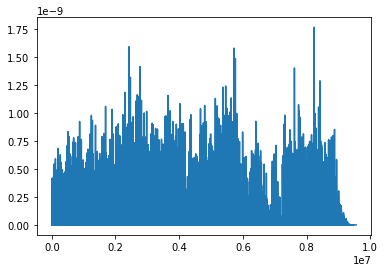

In [9]:
bm_g = cla.empty_like(ts_g)
p0r_g = cla.empty_like(ts_g)
p0i_g = cla.empty_like(ts_g)
ur_g = cla.empty_like(ts_g)
ui_g = cla.empty_like(ts_g)
t0 = time.time()
p0(cosx, p0r_g, decay)
p0(sinx, p0i_g, decay)
p1(p0r_g, decay)
p1(p0i_g, decay)
p1r_g = p0r_g.copy(q)
shift(p1r_g)
p2r_g = p1r_g.copy(q)
shift(p2r_g)

p1i_g = p0i_g.copy(q)
shift(p1i_g)
p2i_g = p1i_g.copy(q)
shift(p2i_g)
u0(p0r_g, p1r_g, p2r_g, ur_g, decay)
u0(p0i_g, p1i_g, p2i_g, ui_g, decay)
bm_maker(ur_g, ui_g, qcos, qsin, bm_g, gain)
cl_x = (bm_g**2).get()
print(f'That took {time.time() - t0} seconds')
plt.plot(cl_x)

that took 0.8252241611480713 seconds


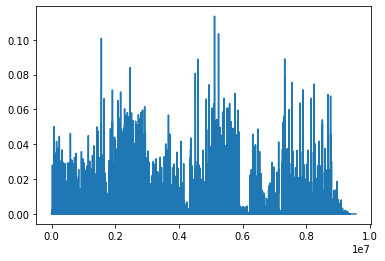

In [19]:
from gammatone import gtgram
t0 = time.time()
coefs = gtgram.make_erb_filters(44100, 5512.5)
x = gtgram.erb_filterbank(samples, coefs)[0]
x = np.power(x, 2)
print(f'that took {time.time() - t0} seconds')
plt.plot(x)

In [21]:
def get_coefficients(signal, fs, cfs):
    samp_g = cla.to_device(q, signal)
    tpt = (M_PI + M_PI) / fs
    ts_g = cla.arange(q, 0, len(signal))
    coefficients = []
    if type(cfs) != list:
        cfs = [cfs]
    for cf in cfs:
        # Calculating the parameters for the given center frequencies
        tptbw = tpt * erb ( cf ) * BW_CORRECTION
        decay = np.exp(-tptbw)
        gain = np.float64((tptbw ** 4) / 3)
        # Setting up memory for everything.
        qcos = cla.empty_like(ts_g)
        qsin = cla.empty_like(ts_g)
        bm_g = cla.empty_like(ts_g)
        p0r_g = cla.empty_like(ts_g)
        p0i_g = cla.empty_like(ts_g)
        ur_g = cla.empty_like(ts_g)
        ui_g = cla.empty_like(ts_g)
        # Preparing the imaginary/real cyclical effects
        q_maker(qcos, qsin, ts_g, tpt, cf)
        cosx = samp_g * qcos
        sinx = samp_g * qsin
        # Performing the filtering operation
        p0(cosx, p0r_g, decay)
        p0(sinx, p0i_g, decay)
        p1(p0r_g, decay)
        p1(p0i_g, decay)
        # Preparing the memory to calculate basilar membrane displacement.
        p1r_g = p0r_g.copy(q)
        shift(p1r_g)
        p2r_g = p1r_g.copy(q)
        shift(p2r_g)
        p1i_g = p0i_g.copy(q)
        shift(p1i_g)
        p2i_g = p1i_g.copy(q)
        shift(p2i_g)
        # Calculating Basilar Membrane displacement
        u0(p0r_g, p1r_g, p2r_g, ur_g, decay)
        u0(p0i_g, p1i_g, p2i_g, ui_g, decay)
        bm_maker(ur_g, ui_g, qcos, qsin, bm_g, gain)
        # Append to the list
        cl_x = (bm_g**2).get()
        coefficients.append(cl_x)

    return np.row_stack(coefficients)

that took 0.14272499084472656 seconds


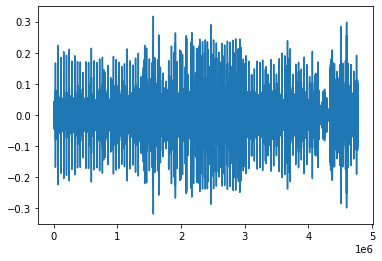

In [27]:
from gammatone import gtgram
t0 = time.time()
coefs = gtgram.make_erb_filters(44100, 5512.5)
x = gtgram.erb_filterbank(samples, coefs)[0]
print(f'that took {time.time() - t0} seconds')
plt.plot(x)

In [97]:
test_g = cla.arange(q, 0, 10, dtype=np.float64)
y_g = cla.zeros_like(test_g)
z_g = cla.zeros_like(test_g)

test_scan = GenericScanKernel(ctx, np.float64,
                              arguments='double *x, double *y, double *z',
                              neutral='0',
                              input_expr='x[i]',
                              scan_expr='a + b',
                              output_statement='y[i] = item, z[i] = y[i] + prev_item')

test_scan(test_g, y_g, z_g)
x = test_g.get()
y = y_g.get()
z = z_g.get()
out = np.row_stack([x,z,y])
print(out)

[[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9.]
 [ 0.  1.  4.  9. 16. 25. 36. 49. 64. 81.]
 [ 0.  1.  3.  6. 10. 15. 21. 28. 36. 45.]]


In [29]:
elem = ElementwiseKernel(ctx,
                         "double *x, double *y",
                         "y[i] = x[i-1] + y[i-1]")

In [30]:
test_g = cla.arange(q, 0, 10, dtype=np.float64)
y_g = cla.zeros_like(test_g)
elem(test_g, y_g)
y_g

array([0., 0., 1., 2., 3., 4., 5., 6., 7., 8.])

NameError: name 'x' is not defined